In [49]:
def remove_parentheses(ss):
    ss = np.array(ss)
    for i in range(ss.size):
        s = ss[i].split('(')
        s = s[0]
        ss[i] = s
    return ss

In [26]:
# Visualizes the location visit durations across different demographic (e.g., emplotyment) and mental health (e.g. depression)
# groups

import pickle
import os
import numpy as np
import pandas as pd

ft_dir = 'features_long/'

# list feature files
files = os.listdir(ft_dir)
# files = [files[0]]

# reading top locations
with open('top_locations.dat') as f:
    location_top = pickle.load(f)
f.close()

# reading assessments
with open('../Assessment/assessment.dat') as f:
    data = pickle.load(f)
f.close()

# reading demographics
with open('../Demographics/demo.dat') as f:
    demo = pickle.load(f)
f.close()

# adding demo to dataframe
data.insert(loc=len(data.columns), column='gender', value=np.nan)
data.insert(loc=len(data.columns), column='age', value=np.nan)
data.insert(loc=len(data.columns), column='employment', value=np.nan)

for (i,subj) in enumerate(data['ID']):
    ind = np.where(demo['ID']==subj)[0][0]
    data.loc[i,'gender'] = demo.loc[ind, 'gender']
    data.loc[i,'age'] = demo.loc[ind, 'age']
    data.loc[i,'employment'] = demo.loc[ind, 'employment']

# adding durations to dataframes
for loc_top in location_top:
    data.insert(loc=len(data.columns), column=loc_top, value=np.nan)

for filename in files:
    with open(ft_dir+filename) as f:  
        feature, target = pickle.load(f)

        ind_subject = np.where(data['ID']==filename[:-4])[0][0]
        
        data.loc[ind_subject, location_top] = 0
        dur_all = 0
        for (i,loc) in enumerate(target['location']):
            if not np.isnan(feature['n gps'][i]):
                if loc in location_top:
                    data.loc[ind_subject, loc] += feature['n gps'][i]
                dur_all += feature['n gps'][i]
            else:
                print 'warning: n gps was nan'
        
        # normalize
        data.loc[ind_subject, location_top] /= dur_all
        
    f.close()

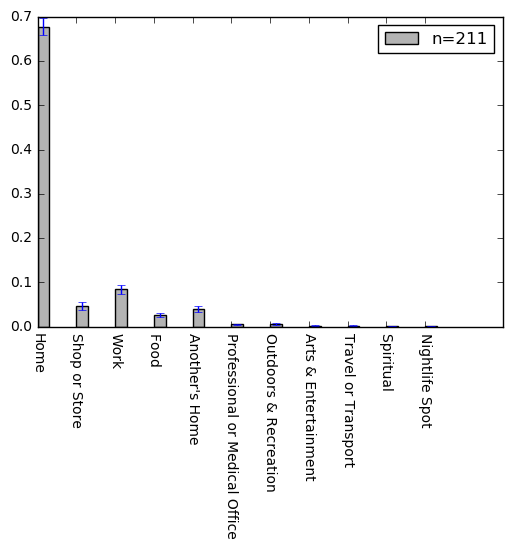

In [50]:
# all subjects

import matplotlib.pyplot as plt
%matplotlib inline

data_loc = data.loc[:,location_top]
mean = np.mean(data_loc, axis=0)
ci = np.std(data_loc, axis=0)/np.sqrt(data_loc.shape[0])

plt.bar(np.arange(mean.size), mean, yerr=ci, width=.3, color=(0.7,0.7,0.7))
plt.xticks(np.arange(mean.size), remove_parentheses(data_loc.columns), rotation=270)
plt.legend(['n={}'.format(data_loc.shape[0])])

In [47]:
location

Index([u'Home', u'Shop or Store', u'Work', u'Food (Restaurant, Cafe)',
       u'Another's Home', u'Professional or Medical Office',
       u'Outdoors & Recreation',
       u'Arts & Entertainment (Theater, Music Venue, Etc.)',
       u'Travel or Transport (Airport, Bus Stop, Train Station, Etc.)',
       u'Spiritual (Church, Temple, Etc.)', u'Nightlife Spot (Bar, Club)'],
      dtype='object')

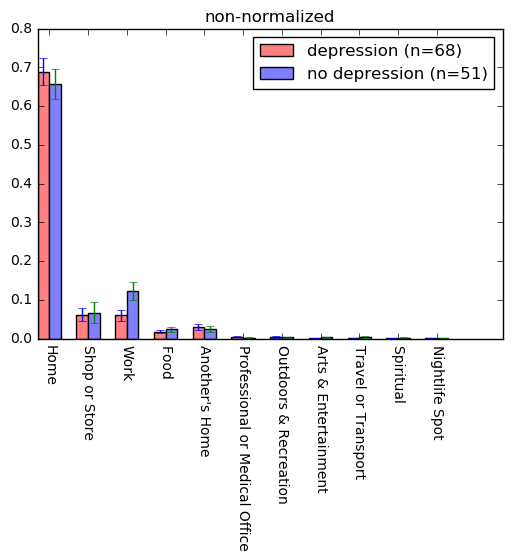

In [60]:
# compare depressed to non-depressed

import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
%matplotlib inline

# option 1: all <> 10
ind_dep = np.where(np.logical_and(np.logical_and(data['PHQ9 W0']>=10, data['PHQ9 W3']>=10), data['PHQ9 W6']>=10))[0]
ind_nodep = np.where(np.logical_and(np.logical_and(data['PHQ9 W0']<10, data['PHQ9 W3']<10), data['PHQ9 W6']<10))[0]

# option 2: average <> 10
# ind_dep = np.where(data['PHQ9 W0']+data['PHQ9 W3']+data['PHQ9 W6']>=30)[0]
# ind_nodep = np.where(data['PHQ9 W0']+data['PHQ9 W3']+data['PHQ9 W6']<30)[0]

# option 3: change <> 0
# ind_dep = np.where(data['PHQ9 W6']-data['PHQ9 W0']>=0)[0]
# ind_nodep = np.where(data['PHQ9 W6']-data['PHQ9 W0']<0)[0]

data_dep = data.loc[ind_dep, list(location_top)]
data_nodep = data.loc[ind_nodep, list(location_top)]

mean_dep = np.mean(data_dep, axis=0)
mean_nodep = np.mean(data_nodep, axis=0)
ci_dep = np.std(data_dep, axis=0)/np.sqrt(data_dep.shape[0])
ci_nodep = np.std(data_nodep, axis=0)/np.sqrt(data_nodep.shape[0])

plt.bar(np.arange(mean_dep.size), mean_dep, yerr=ci_dep, width=.3, color=(1,.5,.5))
plt.bar(np.arange(mean_nodep.size)+.3, mean_nodep, yerr=ci_nodep, width=.3, color=(.5,.5,1))
plt.xticks(np.arange(mean_dep.size)+.3, remove_parentheses(data_dep.columns), rotation=270)
plt.legend(['depression (n={})'.format(data_dep.shape[0]),'no depression (n={})'.format(data_nodep.shape[0])])
plt.title('non-normalized')

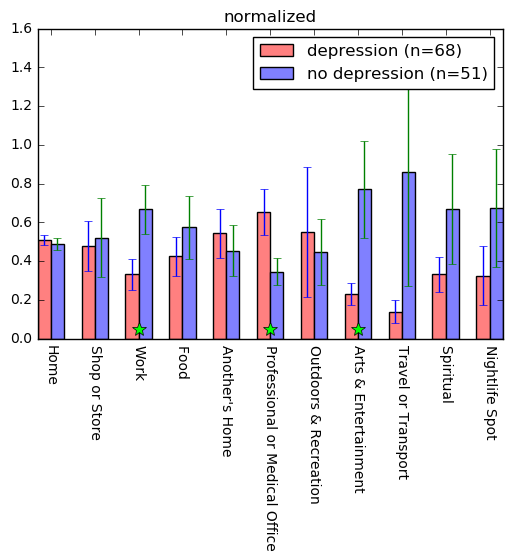

In [61]:
# same plot, normalized

plt.bar(np.arange(mean_dep.size), np.divide(mean_dep,mean_dep+mean_nodep), yerr=np.divide(ci_dep,mean_dep+mean_nodep), width=.3, color=(1,.5,.5))
plt.bar(np.arange(mean_nodep.size)+.3, np.divide(mean_nodep,mean_dep+mean_nodep), yerr=np.divide(ci_nodep,mean_dep+mean_nodep), width=.3, color=(.5,.5,1))
plt.xticks(np.arange(mean_dep.size)+.3, remove_parentheses(data_dep.columns), rotation=270)
plt.legend(['depression (n={})'.format(data_dep.shape[0]),'no depression (n={})'.format(data_nodep.shape[0])])
plt.title('normalized')

# ttest
for (i,loc) in enumerate(location_top):
    _,p = ttest_ind(data_dep.loc[np.logical_not(np.isnan(data_dep.loc[:,loc])),loc], \
                    data_nodep.loc[np.logical_not(np.isnan(data_nodep.loc[:,loc])),loc], equal_var=False)
#     print p
    if p<.05:
        plt.plot(i+.3, 0.05, '*', markersize=10, color=(0,1,0))

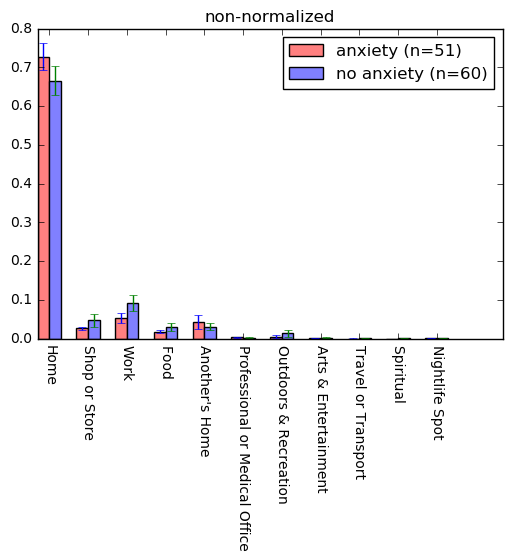

In [62]:
# compare anxious to non-anxious

import matplotlib.pyplot as plt
%matplotlib inline

# option 1: all <> 10
ind_anx = np.where(np.logical_and(np.logical_and(data['GAD7 W0']>=10, data['GAD7 W3']>=10), data['GAD7 W6']>=10))[0]
ind_noanx = np.where(np.logical_and(np.logical_and(data['GAD7 W0']<10, data['GAD7 W3']<10), data['GAD7 W6']<10))[0]

# option 2: average <> 10
# ind_anx = np.where(data['GAD7 W0']+data['GAD7 W3']+data['GAD7 W6']>=30)[0]
# ind_noanx = np.where(data['GAD7 W0']+data['GAD7 W3']+data['GAD7 W6']<30)[0]

# option 3: change <> 0
# ind_anx = np.where(data['GAD7 W6']-data['GAD7 W0']>=0)[0]
# ind_noanx = np.where(data['GAD7 W6']-data['GAD7 W0']<0)[0]

data_anx = data.loc[ind_anx, list(location_top)]
data_noanx = data.loc[ind_noanx, list(location_top)]

mean_anx = np.mean(data_anx, axis=0)
mean_noanx = np.mean(data_noanx, axis=0)
ci_anx = np.std(data_anx, axis=0)/np.sqrt(data_anx.shape[0])
ci_noanx = np.std(data_noanx, axis=0)/np.sqrt(data_noanx.shape[0])

plt.bar(np.arange(mean_anx.size), mean_anx, yerr=ci_anx, width=.3, color=(1,0.5,0.5))
plt.bar(np.arange(mean_noanx.size)+.3, mean_noanx, yerr=ci_noanx, width=.3, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_anx.size)+.3, remove_parentheses(data_anx.columns), rotation=270)
plt.legend(['anxiety (n={})'.format(data_anx.shape[0]),'no anxiety (n={})'.format(data_noanx.shape[0])])
plt.title('non-normalized')

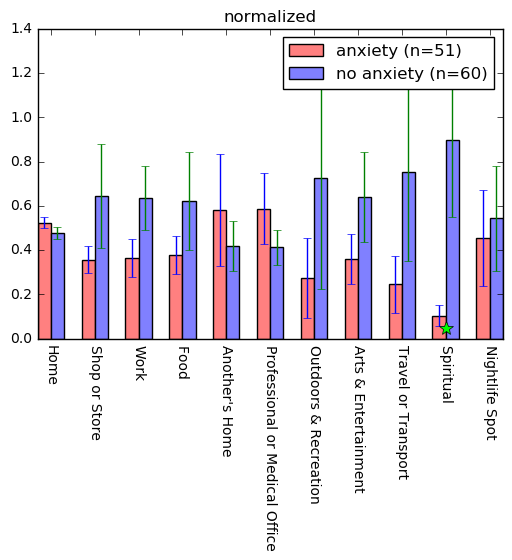

In [63]:
# same but normalized

plt.bar(np.arange(mean_anx.size), np.divide(mean_anx,mean_anx+mean_noanx), yerr=np.divide(ci_anx,mean_anx+mean_noanx), width=.3, color=(1,0.5,0.5))
plt.bar(np.arange(mean_noanx.size)+.3, np.divide(mean_noanx,mean_anx+mean_noanx), yerr=np.divide(ci_noanx,mean_anx+mean_noanx), width=.3, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_anx.size)+.3, remove_parentheses(data_anx.columns), rotation=270)
plt.legend(['anxiety (n={})'.format(data_anx.shape[0]),'no anxiety (n={})'.format(data_noanx.shape[0])])
plt.title('normalized')

# ttest
for (i,loc) in enumerate(location_top):
    _,p = ttest_ind(data_anx.loc[np.logical_not(np.isnan(data_anx.loc[:,loc])),loc], \
                    data_noanx.loc[np.logical_not(np.isnan(data_noanx.loc[:,loc])),loc], equal_var=False)
    if p<.05:
        plt.plot(i+.3, 0.05, '*', markersize=10, color=(0,1,0))

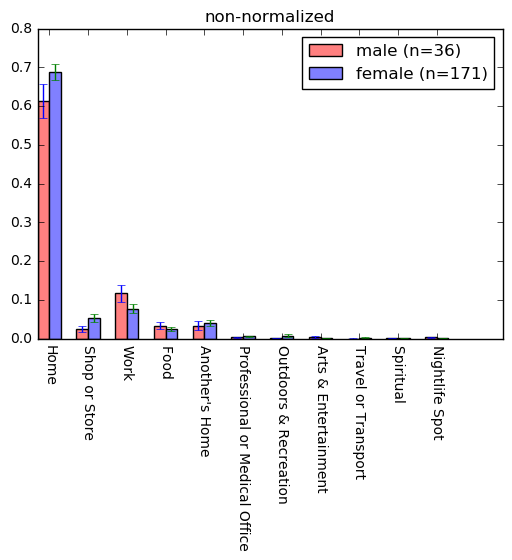

In [64]:
# gender

import matplotlib.pyplot as plt
%matplotlib inline

ind_male = np.where(data['gender']==1)[0]
ind_female = np.where(data['gender']==2)[0]

data_male = data.loc[ind_male, list(location_top)]
data_female = data.loc[ind_female, list(location_top)]

mean_male = np.mean(data_male, axis=0)
mean_female = np.mean(data_female, axis=0)
ci_male = np.std(data_male, axis=0)/np.sqrt(data_male.shape[0])
ci_female = np.std(data_female, axis=0)/np.sqrt(data_female.shape[0])

plt.bar(np.arange(mean_male.size), mean_male, yerr=ci_male, width=.3, color=(1,0.5,0.5))
plt.bar(np.arange(mean_female.size)+.3, mean_female, yerr=ci_female, width=.3, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_male.size)+.3, remove_parentheses(data_male.columns), rotation=270)
plt.legend(['male (n={})'.format(data_male.shape[0]),'female (n={})'.format(data_female.shape[0])])
plt.title('non-normalized')

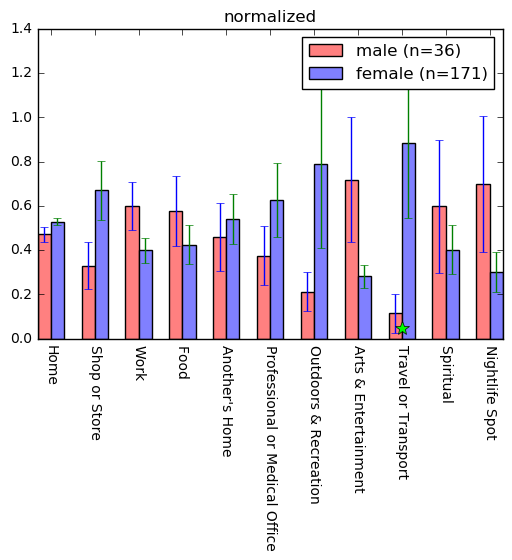

In [65]:
plt.bar(np.arange(mean_male.size), np.divide(mean_male,mean_male+mean_female), yerr=np.divide(ci_male,mean_male+mean_female), width=.3, color=(1,0.5,0.5))
plt.bar(np.arange(mean_female.size)+.3, np.divide(mean_female,mean_male+mean_female), yerr=np.divide(ci_female,mean_male+mean_female), width=.3, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_male.size)+.3, remove_parentheses(data_anx.columns), rotation=270)
plt.legend(['male (n={})'.format(data_male.shape[0]),'female (n={})'.format(data_female.shape[0])])
plt.title('normalized')

# ttest
for (i,loc) in enumerate(location_top):
    _,p = ttest_ind(data_male.loc[np.logical_not(np.isnan(data_male.loc[:,loc])),loc], \
                    data_female.loc[np.logical_not(np.isnan(data_female.loc[:,loc])),loc], equal_var=False)
#     print p
    if p<.05:
        plt.plot(i+.3, 0.05, '*', markersize=10, color=(0,1,0))

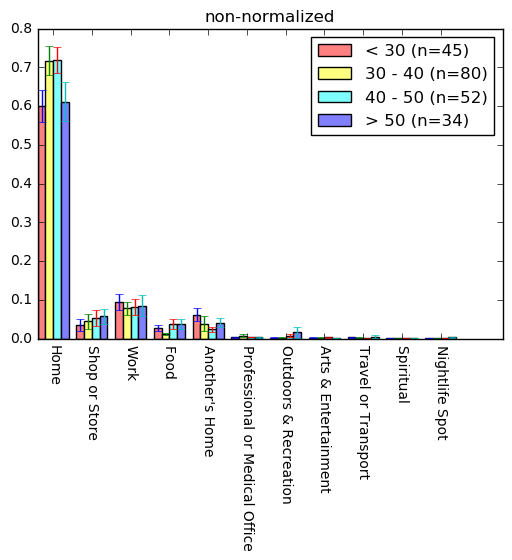

In [66]:
# age

import matplotlib.pyplot as plt
%matplotlib inline

ind_1 = np.where(data['age']<30)[0]
ind_2 = np.where(np.logical_and(data['age']>=30,data['age']<40))[0]
ind_3 = np.where(np.logical_and(data['age']>=40,data['age']<50))[0]
ind_4 = np.where(data['age']>50)[0]

data_1 = data.loc[ind_1, list(location_top)]
data_2 = data.loc[ind_2, list(location_top)]
data_3 = data.loc[ind_3, list(location_top)]
data_4 = data.loc[ind_4, list(location_top)]

mean_1 = np.mean(data_1, axis=0)
mean_2 = np.mean(data_2, axis=0)
mean_3 = np.mean(data_3, axis=0)
mean_4 = np.mean(data_4, axis=0)
ci_1 = np.std(data_1, axis=0)/np.sqrt(data_1.shape[0])
ci_2 = np.std(data_2, axis=0)/np.sqrt(data_1.shape[0])
ci_3 = np.std(data_3, axis=0)/np.sqrt(data_1.shape[0])
ci_4 = np.std(data_4, axis=0)/np.sqrt(data_1.shape[0])

plt.bar(np.arange(mean_1.size), mean_1, yerr=ci_1, width=.2, color=(1,0.5,0.5))
plt.bar(np.arange(mean_2.size)+.2, mean_2, yerr=ci_2, width=.2, color=(1,1,0.5))
plt.bar(np.arange(mean_3.size)+.4, mean_3, yerr=ci_3, width=.2, color=(0.5,1,1))
plt.bar(np.arange(mean_4.size)+.6, mean_4, yerr=ci_4, width=.2, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_male.size)+.4, remove_parentheses(data_male.columns), rotation=270)
plt.legend(['< 30 (n={})'.format(data_1.shape[0]),'30 - 40 (n={})'.format(data_2.shape[0]),\
            '40 - 50 (n={})'.format(data_3.shape[0]), '> 50 (n={})'.format(data_4.shape[0])])
plt.title('non-normalized')

# plt.hist(data['age'])

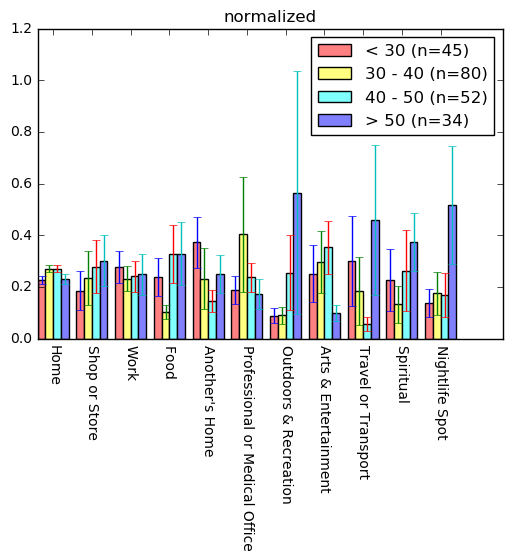

In [67]:
mean_all = mean_1+mean_2+mean_3+mean_4
plt.bar(np.arange(mean_1.size), np.divide(mean_1,mean_all), yerr=np.divide(ci_1,mean_all), width=.2, color=(1,0.5,0.5))
plt.bar(np.arange(mean_2.size)+.2, np.divide(mean_2,mean_all), yerr=np.divide(ci_2,mean_all), width=.2, color=(1,1,0.5))
plt.bar(np.arange(mean_3.size)+.4, np.divide(mean_3,mean_all), yerr=np.divide(ci_3,mean_all), width=.2, color=(0.5,1,1))
plt.bar(np.arange(mean_4.size)+.6, np.divide(mean_4,mean_all), yerr=np.divide(ci_4,mean_all), width=.2, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_1.size)+.4, remove_parentheses(data_1.columns), rotation=270)
plt.legend(['< 30 (n={})'.format(data_1.shape[0]),'30 - 40 (n={})'.format(data_2.shape[0]),\
            '40 - 50 (n={})'.format(data_3.shape[0]), '> 50 (n={})'.format(data_4.shape[0])])
plt.title('normalized')

# ttest -- should change to anova
# for (i,loc) in enumerate(location_top):
#     _,p = ttest_ind(data_male.loc[np.logical_not(np.isnan(data_male.loc[:,loc])),loc], \
#                     data_female.loc[np.logical_not(np.isnan(data_female.loc[:,loc])),loc], equal_var=False)
#     print p
#     if p<.05:
#         plt.plot(i+.3, 0.05, '*', markersize=10, color=(0,1,0))